# Two State - One Control Bellman Equation Model Computation





### **Suraj Kumar**  

**Post Graduation**  
*MA Economics(Final Year)*  
*Department of Economics*  
**Delhi School of Economics**  
*India*

**Under Graduation**    
*B.Tech in Civil Engineering from **Indian Institute of Technology, Delhi (IIT Delhi)***

surajdhunna@gmail.com     
[Github Link of Notebook](https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model/blob/master/Two%20State%20and%20One%20Control%20Bellman%20Equation%20Model.ipynb)

**ACKNOWLEDGEMENT / CREDITS**

This notebook primarly deals with Lucas Asset Pricing Model. I have refered mainly to [QuantEcon Lectures](https://lectures.quantecon.org/). These are fantastic set of lectures for general introduction to quantitative programming. The readers are requested to refer to it to learn more about quantitative programming in python for Economics. For this notebook, I have mainly referred to following lectures of it

1. [Introduction to Asset Pricing](https://lectures.quantecon.org/py/markov_asset.html)
2. [The Lucas Asset Pricing Model](https://lectures.quantecon.org/py/lucas_model.html)
3. [A Stochastic Optimal Growth Model](https://lectures.quantecon.org/py/optgrowth.html)

Therefore, I would like to thank the Authors [QuantEcon Lectures](https://lectures.quantecon.org/) for creating it.

## 1. Introduction

Generally the bellman equation examples in python solves for only one state variable. In this notebook, I have shown a method by which we can solve bellman equation with two state variable and one control variable. This kind of model can be applied to Lucas Asset Pricing Models. This kind of computation program for bellman equation really helps us in understanding the elegance of bellman equation. It is because under some *nice properties(continous and bounded)* of utility and state equation, *every initial guess that is surface iin $3D$ leads to final converged surface as output*.

### 1.1. Lucas Asset Pricing Model
In Lucas economy an asset generates a claim to sequence of such consumption goods (states) or endowment stream $\{y_{t}\}^\infty_{t=0}$. For example the value function and budget constraint for a representative agent in the lucas economy is given below

\begin{align}
&v(\pi,y)  = \max\limits_{\pi'} \bigg \{ u \big[ \pi \big( y + p(y) \big) - \pi' p(y) \big] + \beta \int v(\pi',G(y,z)) \phi(dz) \bigg \}\\
&c(\pi,y) =\pi \big( y + p(y) \big) - \pi' p(y) \\
\end{align}

Here $\pi$ and $\pi'$ denotes the share of an agent of the asset in the current and future period, $G(y,z)$ denotes the state equation which is Markovian as $ y_{t+1} = G(y_t, z_{t+1})$. The $z_t \geq 0$ is an iid shock sequence with a known distribution $\phi$ 

Next step is solve for $v(\pi,y)$ but for this we need to have $p(y)$ function. The $p(y)$ can be evaluated by observing the first order conditions of $v(\pi,y)$ as follows

\begin{align}
&u'(c)p(y) = \beta \int v'_1(\pi',G(y,z))\phi(dz)\\
&\text{where $v'_1$ can be obtained with envelope theorem as shown below}\\
&p(y) = \beta \int \frac{u'[G(y,z]}{u'(y)}[G(y,z) + p(G(y,z))]\phi(dz)
\end{align}

Now applying the transformation $f(y) = u'(y)p(y)$, the above equation becomes
$$f(y) = h(y) + \beta \int f[G(y,z)]\phi(dz)$$

where $h(y) = \beta \int u'[G(y,z)]G(y,z)\phi(dz)$

Now the $f(y)$ can be solved with bellman operator and from derived solution $p(y)$ function can be obtained. For more information, the reader may refer to [QuantEcon's The Lucas Asset Pricing Model](https://lectures.quantecon.org/py/lucas_model.html).

### 1.2 Assumptions

In this notebook, I have focussed on solving, directly, the $v(\pi,y)$ equation which has two states variable $(\pi,y)$ and one control variable $\pi'$. I have assumed that 

$$p(y) = \frac {y}{1-\beta}$$

As without this assumption, We have to first solve for $p(y)$ with bellman operator and then use these derived value to solve for $v(\pi,y)$ which will make code longer and difficult to compute. Thus assumptiong keeps the code simple to comprehend and easy to compute and keep the prime focus of program on computation of $v(\pi,y)$. To ensure the continous and bounded nature of state and utility function, I have made following assumptions:

\begin{align}
&u(c) = (c)^\gamma \text{  where   } 0 < \gamma < 1 \\
&ln(y_{t+1}) = \alpha ln(y_t) + \sigma \epsilon_{t+1} \text{ here } \epsilon_t \text{follows iid standard normal}
\end{align}


## 2. Code

### 2.1. Limitations of the Code

The following code has following limitations

1. As first solution, no speed enhancing computation packages/way such as jit, cython or parallel computing has been used in bellman operator. I have planned include it the next version of this code. So stay tuned to Github repository.


### 2.2. Code

In [212]:
### Importing relevent packages

# To showcase the outputs of all cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Numerican Packages
import numpy as np
from numpy import random
from scipy.stats import lognorm
from scipy.integrate import fixed_quad
from scipy import interpolate
from scipy import optimize

# Plotting Packages
%matplotlib notebook
import matplotlib.pyplot as plt 

# 3D Plotting Packages
from mpl_toolkits import mplot3d

# Impornting 
from numba import jit,njit,vectorize

In [182]:
### Creating a Class to hold the model paramters
class LucasAssetModel:
    """
    Lucas Asset Price Tree model
    This class creates all model parameters needed for the computation 
    """
    
    # Creating the class Paramters
    def __init__(self,
                γ = 0.5,
                β = 0.95,
                α = 0.9,
                μ = 0,
                s = 0.1,
                rent_min = 1e-5,
                rent_max = 4,
                rent_grid_size = 100,
                shock_size = 100,
                seed = 100,
                π_min = 1e-5,
                π_max = 1,
                π_grid_size = 100):
        """
        Creates Instance of Lucas Model
        --------------------------------
        Parameters are defined as below
        --------------------------------
        #Model Parameters
        α: relates the y(t) with y(t-1)
        β: discount factor of agent utility
        γ: Utiltiy parameter of the agent and 0 < γ < 1
        
        # Shock Parameters
        s,μ : Shock Parametes as z_t = e^(μ + s*ϵ_t), ϵ_t is iid shock sequence with N(0,1)
        shock_size: No of shocks to consider
        
        ### State Paramters
        # Rent
        rent_min: minimum y (state) value to consider 
        rent_max: maximum y (state) value to consider 
        rent_grid_size: No of points to select between rent_min and rent_max
        # Share
        π_min: minimum π (share) value to consider
        π_max: maximum π (share) value to consider
        π_grid_size: No. of points to select between π_min and π_max
        
        # Randomness
        seed : For getting the same set of random numbers again and again so as to reproduce the results
        
        """
        ### Assinging Parameters
        
        # Model Parameters
        self.γ, self.β, self.α = γ, β, α
        
        # Shocks Parameters
        self.s, self.μ, self.shock_size, self.seed  = s, μ, shock_size, seed
        
        #Rental Grid State Allocation
        self.rent_min, self.rent_max, self.rent_grid_size  = rent_min, rent_max, rent_grid_size
        self.rent_grid = np.linspace( self.rent_min, self.rent_max, self.rent_grid_size)
        
        #Setting up shocks in the models
        np.random.seed(self.seed) # setting seed to generate same random numbers, 
        #useful for repeating the steps of computation again to see check the result,
        self.shocks = np.exp( self.μ + self.s * np.random.randn(self.shock_size)  )
        
        #Setting up grid for share π
        self.π_min, self.π_max, self.π_grid_size = π_min, π_max, π_grid_size
        self.π_grid = np.linspace(self.π_min, self.π_max, self.π_grid_size)
    
    # Initial Surface to input into bellman operator

    # First Fuction
    def initial_w(self): #Intialzing the grid with some continous, concave function
        pi_s,rent_s = np.meshgrid(self.π_grid, self.rent_grid)
        return 5*np.sqrt(pi_s*rent_s)

    # Second Function
    def initial_w2(self): #Intialzing the grid with some continous, concave function
        pi_s,rent_s = np.meshgrid(self.π_grid, self.rent_grid)
        return np.power(pi_s*rent_s,1/3)
    
    # Solving the Model
    def solve_optvalue(self,
                       tol = 1e-6, 
                       max_iter = 100):
        """
        This function is used to solving the model. Its first extract the parameters to be passed on to bellman operator.
        Then given the modelling preferences i.e tol and max_iter, it solves the model.

        """
        ### Extracting The Parameters from the class object self to be passed on to bellman operator
        # Parameters Extractions
        model_parameters = np.array([self.α, self.β, self.γ])
        
        #Share Grid Extraction
        π_max, π_min,π_grid = self.π_max, self.π_min, self.π_grid

        #Rent Grid Extraction
        rent_grid = self.rent_grid

        #Shocks Grid Extract
        shocks_sequence = self.shocks
        
        #### Initial Function
        w = self.initial_w()
        # w = self.initial_w2() # as second choice for the surface
        
        # Creating Dictionary to see the convergence of surface later on 
        d={}
        
        # Loop paramters
        error = tol + 1
        i = 0
        
        # Storing the first intial 3D surface in dictionary object
        d[0] = w

        #Create Storage for bellman Operator
        Tw = np.empty_like(w)

        #Iterate to find Solution
        while error > tol and i < max_iter:
            w_new = bellman_operator(w,
                                     π_grid,
                                     rent_grid,
                                     model_vars = model_parameters,
                                     shocks = shocks_sequence,
                                     Tw = None, 
                                     compute_policy = 0) #computes the bellman
            error = np.max(np.abs(w_new - w)) # Find the maximum absolute distance between the 
            ################################### two surfaces(w and w_new) over the state space
            w = w_new
            i += 1
            d[i] = w_new # Stores the computed surface in dictionary object, 
            #it can be used later on to see the convergence of the surfaces   

        return w,i,d # Returns converges surface, iterations it took and Surface history

In [191]:
#####NOTE####
#Computation function have been written separtely from class object so as to make code faster 
#later on with the use of numba. At presently numba support for classes i.e @jitclass, is still at
#early stages. 


# Writingn the Utility Function
@njit
def u(π_prime, π, y, p, γ):
    cons = (π*(y + p)) - (π_prime*p)
    return cons**γ

# State Function
@njit
def g(y,z,α):
    return (y**α)*z

# Price Function
@njit
def p(y,β):
    return y/(1-β)
    

# Writing my own Minimum Function to compare against fminbound

def min_fun(objective,π_grid, ans = None):
    if ans is None:
        ans = np.empty_like(π_grid)
    for i, π in enumerate(π_grid):
        ans[i] = objective(π)
    return π_grid[ans == min(ans)]


# Bellman Operator
def bellman_operator(w,
                     π_grid,
                     rent_grid,
                     model_vars,
                     shocks,
                     Tw = None, 
                     compute_policy = 0):
    """
    Parameters
    ------------  
    w = is mesh of different π values and rent(y) values
    π_grid = share grid
    rent_grid = rent grids or y grid
    model_vars = [α, β, γ]
    shocks = shocks value to be used
    Tw = array to output values, Tw is just for computation optimization
    compute_policy = to decide whether to ouput policy function or not

    """ 
    α, β, γ = model_vars
    
    # === Appyling Linear interpolation to a two dimensional surface === #
    interpolation_func = interpolate.interp2d(π_grid, rent_grid, w, kind='linear')
    
   
    # === Intitiate Tw if required === #
    if Tw is None:
        Tw = np.empty_like(w)

    # === Intitate compute policy if asked === #

    if compute_policy:
        π_opt_policy = np.empty_like(w)

    for i, y in enumerate(rent_grid):
        for j, π in enumerate(π_grid):
            def objective(π_prime):
                return - u(π_prime, π, y, p(y,β), γ) - β * np.mean( interpolation_func( π_prime,g(y,shocks,α) ) )
            #π_star = optimize.fminbound(objective, π_grid[0], π_grid[-1])  
            π_star = min_fun(objective,π_grid)
            if compute_policy:
                π_opt_policy[i,j] = π_star
            Tw[i,j] = - objective(π_star)

    if compute_policy:
        return Tw, π_opt_policy
    else:
        return Tw

## 3. Results

### 3.1. Creating an Instance of Model

In [200]:
mylam =LucasAssetModel(rent_grid_size=50,
                       shock_size=1000,
                       π_grid_size=50,
                       seed= 200,
                      rent_min = 1,
                      rent_max = 500,
                      π_min = 1e-2,
                      π_max = 1)

### 3.2 Solving the Model

In [201]:
# Running the Model and Saving the Results
w,i,d = mylam.solve_optvalue(max_iter = 1000,tol = 1e-1)
i

34

### 3.3 Visualizing the Results

#### 3.3.1 Absolute Distance between the subsequent surface after iterations 

In [221]:
# Seeing the Results
distance = [] # setting the distance list which the store the maximum distance between the two subsequence surface
for j in range(len(d)-1):
    distance.append(np.max(d[j+1]-d[j]))

print('First distance is ',distance[0])
print('Last distance is ',distance[i-1])
dis = distance

First distance is  18.0386865678
Last distance is  0.0961541522701


<IPython.core.display.Javascript object>


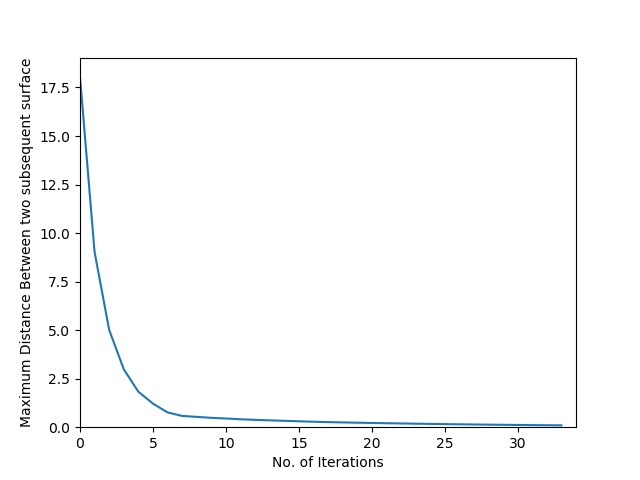

In [222]:
fig = plt.figure()  # a new figure window
ax = fig.add_subplot(111)

ax.plot(dis);
ax.set_ylim(0,max(distance)+1);
ax.set_xlim(0,i);
ax.set_ylabel('Maximum Distance Between two subsequent surface');
ax.set_xlabel('No. of Iterations');

#### 3.3.2 Matplotlib 3D Plots

Here, I plot 5 surfaces on using Matplotlib 3D plot, They are as follows
1. Initial Surface
2. 5 Iterations Surface
3. 10 Iterations Surface
4. 20 Iterations Surface
5. 25 Iterations Surface
6. 30 Iterations Surface
7. 34 Iteations Surface

<IPython.core.display.Javascript object>


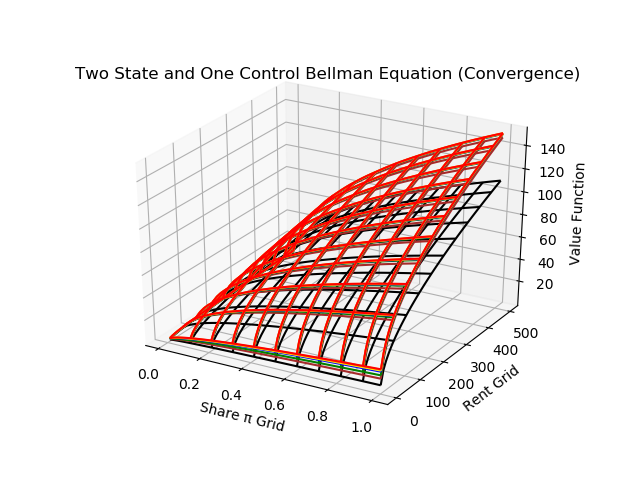

In [224]:
#### Generating Figure

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X,Y = np.meshgrid(mylam.π_grid,mylam.rent_grid)
ax = plt.axes(projection='3d');

#Choosen following Surface to plot on Fiure
choosen_iterations = [0,5,10,20,25,30,34]
colors_iterations  = ['black','brown','green', 'blue', 'yellow', 'orange','red']

for iter,c in zip(choosen_iterations,colors_iterations):
     ax.plot_wireframe(X, Y, d[iter], rstride=5, cstride=5,color = c ); #Mesh Plot

ax.set_title('Two State and One Control Bellman Equation (Convergence)');
ax.set_ylabel('Rent Grid');
ax.set_xlabel('Share π Grid');
ax.set_zlabel('Value Function');